In [42]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from einops import rearrange, repeat
from ome_types import from_xml

In [4]:
# ome tiff created in multiplex_imaging_analysis notebook
ome_path = Path('../data/20240705_Human_BRCA_HT704B1_CODEX_1/20240705_Human_BRCA_HT704B1_CODEX_1.ome.tiff')
assert ome_path.is_file()

## Reading in the OME-TIF

First we create a TiffFile object

In [5]:
tf = tifffile.TiffFile(ome_path)
tf

<tifffile.TiffFile '20240705_Human_B…ODEX_1.ome.tiff'>

### Reading metadata

We'll create a model of the ome tiff with the ome_types library.

It has all fields listed in the [OME-TIF specification ](https://www.openmicroscopy.org/Schemas/Documentation/Generated/OME-2016-06/ome.html)

In [8]:
ome = from_xml(tf.ome_metadata)
ome

OME(
   images=[<1 field_type>],
   structured_annotations={'xml_annotations': [], 'file_annotations': [], 'list_annotations': [], 'long_annotations': [], 'double_annotations': [], 'comment_annotations': [], 'boolean_annotations': [], 'timestamp_annotations': [], 'tag_annotations': [], 'term_annotations': [], 'map_annotations': []},
)

grabbing the actual image metadata

In [16]:
image = ome.images[0]
pixels = image.pixels
channels = pixels.channels

pixels

Pixels(
   id='Pixels:0',
   channels=[<38 field_type>],
   tiff_data_blocks=[{'plane_count': 38}],
   planes=[<38 field_type>],
   dimension_order='XYCZT',
   type='uint8',
   big_endian=False,
   size_x=19200,
   size_y=60480,
   size_z=1,
   size_c=38,
   size_t=1,
   physical_size_x=0.5100762527233116,
   physical_size_y=0.5100762527233116,
)

For here we'll list some common metadata fields

In [18]:
# resolution unit
pixels.physical_size_x_unit

<UnitsLength.MICROMETER: 'µm'>

In [17]:
# physical_size_x, physical_size_y - the image resolution in microns per pixel
pixels.physical_size_x, pixels.physical_size_y

(0.5100762527233116, 0.5100762527233116)

In [19]:
# size_x, size_y - the width and height of the image in pixels
pixels.size_x, pixels.size_y

(19200, 60480)

In [20]:
# size_c - number of channels (markers) in the image
pixels.size_c

38

In [21]:
# listing all channel names
names = [channel.name for channel in channels]
names

['DAPI',
 'Granzyme B',
 'Keratin 5',
 'PLAT/tPA (D)',
 'CTLA4 (D)',
 'CD31',
 'CD4 (D)',
 'SLC39A6 (D)',
 'TCF-1',
 'BCA1',
 'CD68',
 'CD39',
 'FOXP3',
 'CD163',
 'PD-1',
 'MLPH',
 'CD8',
 'HER2 (D)',
 'GLUT1 (D)',
 'ckit-(D)',
 'Pan-Cytokeratin',
 'HIF1a',
 'Podoplanin (D)',
 'CD20',
 'HLA-DR',
 'CK14 (D)',
 'TFF1 (D)',
 'MGP (D)',
 'Ki67',
 'Vimentin',
 'CD3e',
 'E-cadherin',
 'SMA (D)',
 'cd11b',
 'PR (D)',
 'CD45 (D)',
 'GATA3',
 'COX6C (D)']

### Reading in pixel data

In [22]:
# to read in the actual pixel data for a specific channel, we can do the following
idx = names.index('Pan-Cytokeratin') # get index of the channel
x = tf.pages[idx].asarray()
x.shape # (height, width)

(60480, 19200)

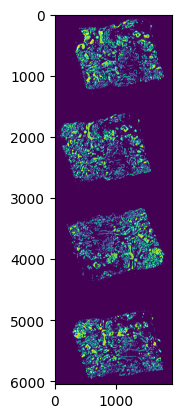

In [23]:
# lets show it, we can downsample the image so it displays faster
plt.imshow(x[::10, ::10])

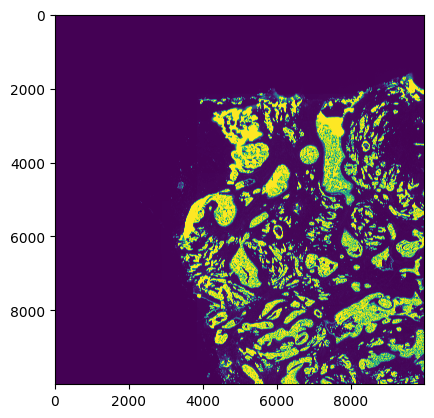

In [24]:
# we can also subset the image based on row and column pixel coordinates
small = x[:10000, :10000]
plt.imshow(small)

### Viewing images as pseudocolor

In [37]:
def hex_to_rgb(
    hex_str: str # hex color
) -> np.ndarray:
    hex_str = hex_str.lstrip("#")
    x = np.asarray([int(hex_str[i:i+2], 16) for i in (0, 2, 4)]).astype(float)
    x /= 255
    return x

In [74]:
def to_pseudocolor(
    data: np.ndarray, # (C, H, W)
    view_settings: dict
) -> np.ndarray:
    """
    data - (c, h, w)
    view_settings - list of dicts that have the following fields:
        color - hex color for channel
        min_value - min value for channel
        max_value - max value for channel
        gamma - gamma value for channel
    """
    channels = [x['channel'] for x in view_settings]
    rgbs = np.stack([hex_to_rgb(x['color']) for x in view_settings])
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
        
    scaled = data / np.iinfo(data.dtype).max
    
    min_values = np.asarray(min_values) / np.iinfo(data.dtype).max
    max_values = np.asarray(max_values) / np.iinfo(data.dtype).max
    if gammas is not None:
        gammas = np.asarray(gammas)
        
    for i, val in enumerate(min_values):
        scaled[i][scaled[i] < val] = 0.
    for i, val in enumerate(max_values):
        scaled[i][scaled[i] > val] = val

    scaled -= scaled.min((1, 2), keepdims=True)
    scaled /= scaled.max((1, 2), keepdims=True)

    # gamma
    if gammas is not None:
        scaled **= rearrange(gammas, 'n -> n 1 1')

    scaled += 1e-16

    stacked = repeat(scaled, 'c h w -> c 3 h w ') * rearrange(rgbs, 'c n -> c n 1 1')

    rgb = rearrange(stacked.sum(0), 'c h w -> h w c')
    rgb[rgb>1] = 1.
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

We define which channels and how to display them in view_settings.

It is a list of dictionaries, each dictionary has the following keys
- channel - name of the channel
- color - hex string of the color to display channel as
- min_value - all pixel intensities below this value will be set to this value, range of the image values is usually 0-255
- max_value - all pixel intensities above this value will be set to this value, range of the image values is usually 0-255
- gamma - gamma contrast value


In [79]:
view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'Pan-Cytokeratin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'HLA-DR',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
]

to_view = [x['channel'] for x in view_settings]
data = np.stack([
    tf.pages[names.index(name)].asarray()
    for name in to_view
])

# downsampling here by factor of 10 just so the conversion runs faster for the example
# don't run this line if you want to do a pseudocolor that is the same size of the actual image
data = data[..., ::10, ::10]

data.shape # (channels, height, width)

(3, 6048, 1920)

In [80]:
rgb = to_pseudocolor(data, view_settings)
rgb.shape # (height, width, rgb)

(6048, 1920, 3)

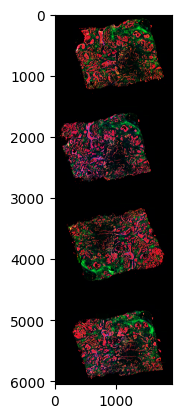

In [81]:
plt.imshow(rgb)

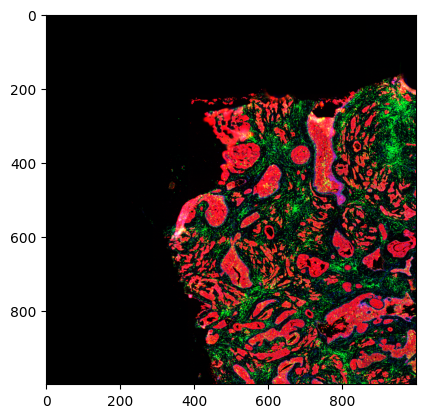

In [82]:
plt.imshow(rgb[:1000, :1000])